In [27]:
import os
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [28]:
import torch
import torch.nn as nn
from tqdm import tqdm
from omegaconf import DictConfig
import hydra

# 必要なインポート (ユーザーの環境に既に存在することを前提とします)
from metric.action_with_image import CattleActionDataModule
from train.interaction_with_image import (
    LitHybridStreamFusion,
    CattleInteractionDataModule,
)


def compute_action_embeddings(
    cfg: DictConfig,
    interaction_model_checkpoint_path: str = "./checkpoints/interaction_finetuned.ckpt"
):
    """
    Actionデータセットに対し、「インタラクション識別モデル」のViTバックボーンを用いて
    単体行動の特徴量を計算する。
    """
    print("--- Calculating Action embeddings (using Interaction model's backbone) ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 特徴量抽出器としてインタラクション識別モデルをロード
    interaction_model = LitHybridStreamFusion.load_from_checkpoint(
        interaction_model_checkpoint_path, map_location=device
    )
    # 単体行動の特徴量抽出器（ViTバックボーン）を取り出す
    feature_extractor = interaction_model.backbone_vit
    feature_adapter = interaction_model.vit_feature_projector
    feature_extractor_pipeline = nn.Sequential(
        feature_extractor,
        feature_adapter
    )
    feature_extractor_pipeline.to(device)
    feature_extractor_pipeline.eval()

    # データはAction用DataModuleで読み込む
    data_module = CattleActionDataModule(data_cfg=cfg.data, aug_cfg=cfg.augmentation)
    data_module.setup("fit")
    test_loader = data_module.test_dataloader()

    all_embeddings, all_labels, all_paths = [], [], []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Calculating Action embeddings"):
            imgs, _, labels, supp_infos = batch
            imgs, labels = imgs.to(device), labels.view(-1)

            raw_embeddings = feature_extractor_pipeline(imgs)
            embeddings = nn.functional.normalize(raw_embeddings, p=2, dim=1)
            
            paths = supp_infos['image_path']
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels.cpu())
            all_paths.extend(paths)

    action_embeddings = torch.cat(all_embeddings, dim=0)
    action_labels = torch.cat(all_labels, dim=0)
    
    return action_embeddings, action_labels, all_paths


def compute_interaction_embeddings(
    cfg: DictConfig,
    interaction_model_checkpoint_path: str = "./checkpoints/interaction_finetuned.ckpt"
):
    """
    Interactionデータセットに対し、「インタラクション識別モデル」の最終層手前から
    インタラクション全体の特徴量を計算する。
    """
    print("--- Calculating Interaction embeddings (from Classifier model) ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 特徴量抽出のためインタラクション識別モデルをロード
    model = LitHybridStreamFusion.load_from_checkpoint(
        interaction_model_checkpoint_path, map_location=device
    )
    # 最終分類層を恒等写像に置き換え、特徴量抽出器として機能させる
    feature_extractor = model.backbone_cnn
    feature_adapter = model.cnn_feature_projector
    feature_extractor_pipeline = nn.Sequential(
        feature_extractor,
        feature_adapter
    )
    feature_extractor_pipeline.to(device)
    feature_extractor_pipeline.eval()

    # データはInteraction用DataModuleで読み込む
    data_module = CattleInteractionDataModule(data_cfg=cfg.data, aug_cfg=cfg.augmentation)
    data_module.setup("fit")
    test_loader = data_module.test_dataloader()

    all_embeddings, all_labels, all_paths = [], [], []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Calculating Interaction embeddings"):
            images1, images2, images_context, labels, supp_infos = batch
            images1, images2, images_context = (
                images1.to(device),
                images2.to(device),
                images_context.to(device),
            )
            raw_embeddings = feature_extractor_pipeline(images_context)
            embeddings = nn.functional.normalize(raw_embeddings, p=2, dim=1)

            paths = supp_infos['image_path']
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels.view(-1).cpu())
            all_paths.extend(paths)

    interaction_embeddings = torch.cat(all_embeddings, dim=0)
    interaction_labels = torch.cat(all_labels, dim=0)

    return interaction_embeddings, interaction_labels, all_paths

In [29]:
ckpt_path = '/home/nakagawa/wrap_monitor_system/checkpoints_dev/best-f1score-finetune-interaction-14_pretrained_attention_aug_pose_pfl_infonce-v1.ckpt'
# 1. 行動推定の計算 (パスも受け取る)
with hydra.initialize(config_path="../metric/conf", version_base=None):
    cfg_action = hydra.compose(config_name="action_train")
    action_embeddings, action_labels, action_paths = compute_action_embeddings(cfg_action, ckpt_path)

# 2. インタラクション推定の計算 (パスも受け取る)
with hydra.initialize(config_path="../train/conf", version_base=None):
    cfg_interaction = hydra.compose(config_name="interaction_train")
    interaction_embeddings, interaction_labels, interaction_paths = compute_interaction_embeddings(cfg_interaction, ckpt_path)

/home/nakagawa/.local/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'action_train': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
/home/nakagawa/.local/lib/python3.8/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seri

--- Calculating Action embeddings (using Interaction model's backbone) ---
Loading ViT backbone weights from checkpoint: checkpoints/action_metric_learning.ckpt


/home/nakagawa/wrap_monitor_system/train/interaction_with_image.py:196: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location=self.de

Freezing ViT backbone weights.


Calculating Action embeddings: 100%|██████████| 61/61 [00:04<00:00, 12.88it/s]
/home/nakagawa/.local/lib/python3.8/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'interaction_train': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
/home/nakagawa/.local/lib/python3.8/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loa

--- Calculating Interaction embeddings (from Classifier model) ---
Loading ViT backbone weights from checkpoint: checkpoints/action_metric_learning.ckpt


/home/nakagawa/wrap_monitor_system/train/interaction_with_image.py:196: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location=self.de

Freezing ViT backbone weights.
Using skeleton-aware augmentation.
Calculated class counts for LDAMLoss: [2333, 1237, 24, 110]


Calculating Interaction embeddings: 100%|██████████| 37/37 [00:03<00:00, 10.64it/s]


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import umap
from sklearn.manifold import TSNE

def reduce_dimension(embeddings, method='umap', random_state=42):
    """
    指定された手法（UMAPまたはt-SNE）で埋め込みベクトルの次元削減を行う。

    Args:
        embeddings (np.ndarray): 次元削減の対象となる高次元の埋め込みベクトル。
        method (str): 使用する次元削減手法を指定する ('umap' または 'tsne')。
        random_state (int): 結果の再現性を担保するための乱数シード。

    Returns:
        np.ndarray: 2次元に削減された埋め込みベクトル。
    """
    if method == 'umap':
        # UMAPによる次元削減
        reducer = umap.UMAP(
            n_neighbors=50,
            min_dist=0.1,
            metric='cosine',
            n_components=2,
            random_state=random_state
        )
    elif method == 'tsne':
        # t-SNEによる次元削減
        reducer = TSNE(
            n_components=2,
            perplexity=30,  # データに応じて調整が必要な主要ハイパーパラメータ
            metric='cosine',
            random_state=random_state
        )
    else:
        raise ValueError("methodは 'umap' または 'tsne' を指定する必要がある。")

    embeddings_2d = reducer.fit_transform(embeddings)
    return embeddings_2d

raw_embeddings = np.vstack([action_embeddings, interaction_embeddings])
labels = np.concatenate([action_labels, interaction_labels])
types = ['action'] * len(action_embeddings) + ['interaction'] * len(interaction_embeddings)
paths = action_paths + interaction_paths

In [31]:
import numpy as np
from sklearn.decomposition import PCA

# --- 3. PCAによる次元削減 ---
# 削減後の次元数を指定する。
n_components = 30
pca = PCA(n_components=n_components)

# PCAを適用し、次元削減を実行する。
reduced_embeddings = pca.fit_transform(raw_embeddings)

# 各主成分の寄与率
explained_variance_ratio = pca.explained_variance_ratio_
# 累積寄与率
cumulative_contribution_ratio = np.cumsum(explained_variance_ratio)
print(f"\n第{n_components}主成分までの累積寄与率は {cumulative_contribution_ratio[-1]:.2%}")

# --- 4. 結果の確認 ---
# 次元削減前後のデータの形状を出力して確認する。
print(f"削減前の次元: {raw_embeddings.shape}")
print(f"削減後の次元: {reduced_embeddings.shape}")


第30主成分までの累積寄与率は 96.05%
削減前の次元: (1896, 768)
削減後の次元: (1896, 30)


In [32]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# from PIL import Image
# import os
# from IPython.display import display


# action_embeddings_2d = reduce_dimension(action_embeddings, method='umap', random_state=42)

# # %%
# # ラベルとクラス名のマッピングを定義
# action_map = {0: 'grazing', 1: 'standing', 2: 'lying', 3: 'riding', -1: 'unknown'}
# interaction_map = {0: 'no_interaction', 1: 'interest', 2: 'conflict', 3: 'mount'}

# # --- 修正: DataFrameに画像パスの列を追加 ---
# df = pd.DataFrame({
#     'x': action_embeddings_2d[:, 0],
#     'y': action_embeddings_2d[:, 1],
#     'label': action_labels,
#     'type': ['action'] * len(action_embeddings),
#     'path': action_paths  # 画像パスの列
# })


# fig, ax = plt.subplots(figsize=(10, 8))
# markers = {'action': 'o', 'interaction': '^'}
# manual_colors = [
#     '#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4',
#     '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8',
#     '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9'
# ]
# gray_color = '#808080'  # 'no_interaction'に割り当てる灰色

# # 'action'と'interaction'それぞれのユニークなラベルリストを取得
# action_labels_unq = sorted(df[df['type'] == 'action']['label'].unique())
# interaction_labels_unq = sorted(df[df['type'] == 'interaction']['label'].unique())

# # 'action'用のカラーマップを作成
# color_map_action = {label: manual_colors[i % len(manual_colors)] for i, label in enumerate(action_labels_unq)}

# # --- 【修正点】'no_interaction'の色を灰色に固定するロジックを追加 ---

# # 'no_interaction'に対応する数値ラベルをinteraction_mapから検索
# no_interaction_label_num = None
# # interaction_map変数が存在し、辞書であることを確認
# if 'interaction_map' in locals() and isinstance(interaction_map, dict):
#     for num, name in interaction_map.items():
#         if name == 'no_interaction':
#             no_interaction_label_num = num
#             break

# # 'interaction'用のカラーマップを作成
# color_map_interaction = {}
# offset = len(action_labels_unq)
# color_index = 0
# for label in interaction_labels_unq:
#     if label == no_interaction_label_num:
#         # 'no_interaction'には指定の灰色を割り当てる
#         color_map_interaction[label] = gray_color
#     else:
#         # その他のinteractionラベルにはリストから順に色を割り当てる
#         color_map_interaction[label] = manual_colors[(color_index + offset) % len(manual_colors)]
#         color_index += 1

# # タイプ名をキーとして、それぞれのカラーマップを格納
# color_map = {
#     'action': color_map_action,
#     'interaction': color_map_interaction
# }

# def get_label_name(numeric_label, type_name):
#     if type_name == 'action': return action_map.get(numeric_label)
#     elif type_name == 'interaction': return interaction_map.get(numeric_label)
#     return None

# # --- プロット描画ループ (このループ内のロジックは変更なし) ---
# for type_name in df['type'].unique():
#     for label_num in df[df['type'] == type_name]['label'].unique():
#         subset = df[(df['label'] == label_num) & (df['type'] == type_name)]
#         if not subset.empty:
#             label_name = get_label_name(label_num, type_name)
#             if label_name is not None:
#                 ax.scatter(subset['x'], subset['y'], c=[color_map[type_name].get(label_num, '#808080')],
#                            marker=markers[type_name], label=f'{label_name}', alpha=0.8, s=50,
#                            edgecolors='black', linewidths=0.5)

# handles, current_labels = ax.get_legend_handles_labels()
# by_label = dict(zip(current_labels, handles))
# ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.2, 1), loc='upper left')
# fig.tight_layout()
# plt.show()

In [33]:
use_pca_reduced = True
if use_pca_reduced:
    embeddings = reduced_embeddings
else:
    embeddings = raw_embeddings

reducer_name = 'tsne'  # 'umap' または 'tsne'
embeddings_2d = reduce_dimension(embeddings, method=reducer_name, random_state=42)
print(f"次元削減後の形状: {embeddings_2d.shape}")

次元削減後の形状: (1896, 2)


In [34]:
# %%
# ラベルとクラス名のマッピングを定義
action_map = {0: 'grazing', 1: 'standing', 2: 'lying', 3: 'riding', -1: 'unknown'}
interaction_map = {0: 'no_interaction', 1: 'interest', 2: 'conflict', 3: 'mount'}

# --- 修正: DataFrameに画像パスの列を追加 ---
df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'label': labels,
    'type': types,
    'path': paths  # 画像パスの列
})

In [35]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np

def compute_robust_mean_embeddings(
    embeddings: torch.Tensor,
    labels: torch.Tensor,
    n_clusters: int,
):
    """
    ラベルごとに埋め込みをクラスタリングし、得られたセントロイドを平均化して、
    単一の頑健な代表ベクトルを計算する。

    Args:
        embeddings (torch.Tensor): サンプルごとの埋め込みベクトル (N, D)
        labels (torch.Tensor): サンプルごとのラベル (N,)
        n_clusters (int): 各ラベル内で作成するクラスタの数

    Returns:
        Tuple[torch.Tensor, torch.Tensor]:
            - ラベルごとの頑健な平均埋め込みベクトル (num_classes, D)
            - 対応するユニークなラベルのテンソル (num_classes,)
    """
    unique_labels = torch.unique(labels)
    robust_mean_embeddings = []

    for label_id in unique_labels:
        label_mask = (labels == label_id)
        embeddings_for_label = embeddings[label_mask]
        
        # サンプル数がクラスタ数より少ない場合、単純平均を計算
        if embeddings_for_label.shape[0] < n_clusters:
            print(f"警告: ラベルID {label_id.item()} のサンプル数 ({embeddings_for_label.shape[0]}) がクラスタ数 ({n_clusters}) より少ないため、単純平均を使用します。")
            mean_embedding = embeddings_for_label.mean(dim=0)
        else:
            # K-Meansクラスタリングを実行
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
            # データをCPU上のNumPy配列に変換
            embeddings_np = embeddings_for_label.cpu().numpy()
            kmeans.fit(embeddings_np)
            
            # 得られたセントロイドをテンソルに変換
            centroids = torch.from_numpy(kmeans.cluster_centers_).to(embeddings.device, dtype=embeddings.dtype)
            
            # セントロイドを平均化して単一の代表ベクトルとする
            mean_embedding = centroids.mean(dim=0)
            
        robust_mean_embeddings.append(mean_embedding)

    # リストをテンソルにスタック
    return torch.stack(robust_mean_embeddings), unique_labels


def calculate_and_display_similarity(
    action_label_embeddings: torch.Tensor,
    interaction_label_embeddings: torch.Tensor,
    action_label_names: list,
    interaction_label_names: list,
):
    """
    2種類のラベル埋め込み間のコサイン類似度を計算し、DataFrame形式で表示する。
    この関数は元のコードから変更不要である。
    """
    # L2正規化
    action_embeds_norm = nn.functional.normalize(action_label_embeddings, p=2, dim=1)
    interaction_embeds_norm = nn.functional.normalize(interaction_label_embeddings, p=2, dim=1)

    # コサイン類似度行列の計算
    similarity_matrix = torch.matmul(action_embeds_norm, interaction_embeds_norm.T)

    # 結果をPandas DataFrameで整形
    df = pd.DataFrame(
        similarity_matrix.cpu().numpy(),
        index=action_label_names,
        columns=interaction_label_names
    )
    print("\n--- Cosine Similarity between Action and Interaction Labels (Robust Mean) ---")
    print(df.to_string())


# --- 以下、実行部分 ---
# 動作確認用のサンプルデータを生成
# D = 64
# action_embeddings = torch.randn(200, D)
# action_labels = torch.randint(0, 3, (200,))
# interaction_embeddings = torch.randn(250, D)
# interaction_labels = torch.randint(0, 4, (250,))
# action_map = {0: 'walk', 1: 'run', 2: 'jump'}
# interaction_map = {0: 'with_ball', 1: 'with_friend', 2: 'alone', 3: 'on_stairs'}

# 各ラベル内で抽出する代表点の数（これを平均化する）
N_CLUSTERS_PER_LABEL = 5

# クラスタリングと平均化によって頑健な代表ベクトルを計算
action_label_embeddings, unique_action_indices = compute_robust_mean_embeddings(
    action_embeddings, 
    action_labels, 
    n_clusters=N_CLUSTERS_PER_LABEL
)
interaction_label_embeddings, unique_interaction_indices = compute_robust_mean_embeddings(
    interaction_embeddings, 
    interaction_labels, 
    n_clusters=N_CLUSTERS_PER_LABEL
)

# ラベル名を取得
action_label_names = [action_map.get(i.item(), f'unknown_action_{i.item()}') for i in unique_action_indices]
interaction_label_names = [interaction_map.get(i.item(), f'unknown_interaction_{i.item()}') for i in unique_interaction_indices]

# 類似度を計算して表示
calculate_and_display_similarity(
    action_label_embeddings,
    interaction_label_embeddings,
    action_label_names,
    interaction_label_names,
)


--- Cosine Similarity between Action and Interaction Labels (Robust Mean) ---
          no_interaction  interest  conflict     mount
grazing         0.806359  0.815897  0.818608  0.732630
standing        0.821952  0.822970  0.818298  0.752584
lying           0.819414  0.824274  0.820361  0.737133
riding          0.799475  0.781977  0.760653  0.765821


In [36]:
# %pip install ipympl ipywidgets
%matplotlib ipympl

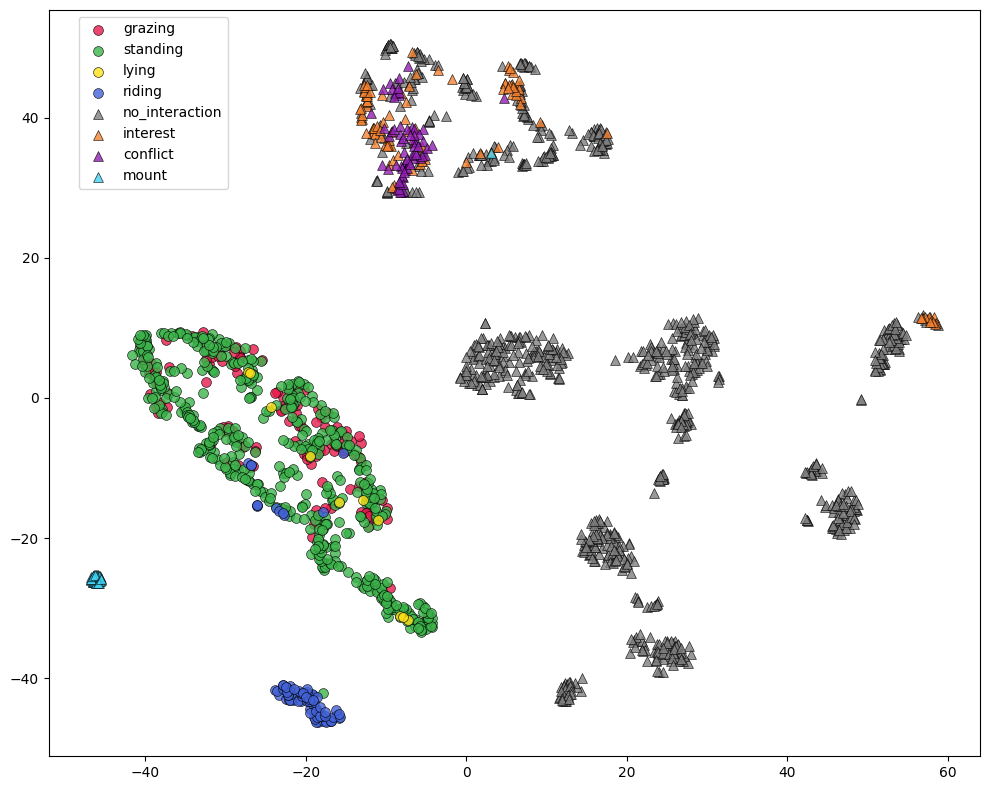

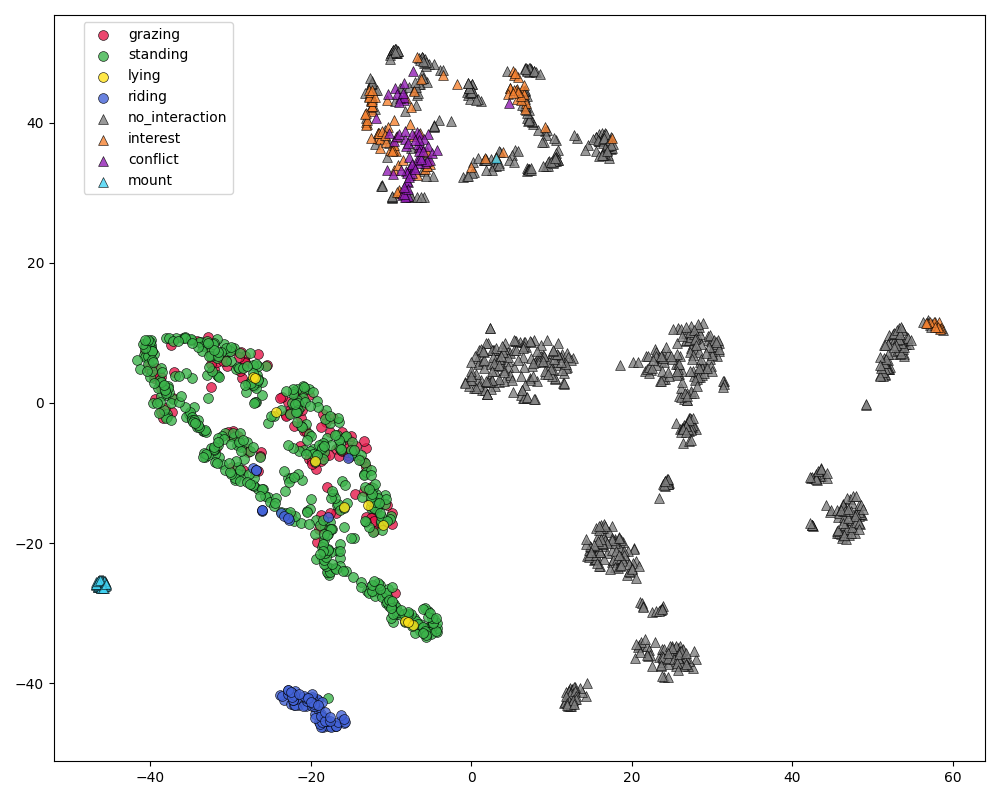

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
from IPython.display import display

fig, ax = plt.subplots(figsize=(10, 8))
markers = {'action': 'o', 'interaction': '^'}
manual_colors = [
    '#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4',
    '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8',
    '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9'
]
gray_color = '#808080'  # 'no_interaction'に割り当てる灰色

# 'action'と'interaction'それぞれのユニークなラベルリストを取得
action_labels_unq = sorted(df[df['type'] == 'action']['label'].unique())
interaction_labels_unq = sorted(df[df['type'] == 'interaction']['label'].unique())

# 'action'用のカラーマップを作成
color_map_action = {label: manual_colors[i % len(manual_colors)] for i, label in enumerate(action_labels_unq)}

# --- 【修正点】'no_interaction'の色を灰色に固定するロジックを追加 ---

# 'no_interaction'に対応する数値ラベルをinteraction_mapから検索
no_interaction_label_num = None
# interaction_map変数が存在し、辞書であることを確認
if 'interaction_map' in locals() and isinstance(interaction_map, dict):
    for num, name in interaction_map.items():
        if name == 'no_interaction':
            no_interaction_label_num = num
            break

# 'interaction'用のカラーマップを作成
color_map_interaction = {}
offset = len(action_labels_unq)
color_index = 0
for label in interaction_labels_unq:
    if label == no_interaction_label_num:
        # 'no_interaction'には指定の灰色を割り当てる
        color_map_interaction[label] = gray_color
    else:
        # その他のinteractionラベルにはリストから順に色を割り当てる
        color_map_interaction[label] = manual_colors[(color_index + offset) % len(manual_colors)]
        color_index += 1

# タイプ名をキーとして、それぞれのカラーマップを格納
color_map = {
    'action': color_map_action,
    'interaction': color_map_interaction
}

def get_label_name(numeric_label, type_name):
    if type_name == 'action': return action_map.get(numeric_label)
    elif type_name == 'interaction': return interaction_map.get(numeric_label)
    return None

# --- プロット描画ループ (このループ内のロジックは変更なし) ---
for type_name in df['type'].unique():
    for label_num in df[df['type'] == type_name]['label'].unique():
        subset = df[(df['label'] == label_num) & (df['type'] == type_name)]
        if not subset.empty:
            label_name = get_label_name(label_num, type_name)
            if label_name is not None:
                ax.scatter(subset['x'], subset['y'], c=[color_map[type_name].get(label_num, '#808080')],
                           marker=markers[type_name], label=f'{label_name}', alpha=0.8, s=50,
                           edgecolors='black', linewidths=0.5)

handles, current_labels = ax.get_legend_handles_labels()
by_label = dict(zip(current_labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.2, 1), loc='upper right')
fig.tight_layout()


# ---【機能変更】クリックした点の情報を記録し、別ウィンドウで画像を表示する ---

# クリックした点の情報を保存するためのリストを初期化
clicked_points_history = []

def find_closest_point_info(x, y, dataframe):
    """指定された座標に最も近い点の情報をDataFrameから検索する"""
    distances = np.sqrt((dataframe['x'] - x)**2 + (dataframe['y'] - y)**2)
    closest_idx = distances.idxmin()
    return dataframe.loc[closest_idx]

def onclick(event):
    """グラフがクリックされた際のイベントハンドラ"""
    if event.inaxes != ax:
        return
    
    x, y = event.xdata, event.ydata
    
    # 最も近い点の情報を取得
    closest_info = find_closest_point_info(x, y, df)
    image_path = closest_info['path']
    label_name = get_label_name(closest_info['label'], closest_info['type'])
    
    # 1. クリック情報の記録
    point_data = {
        'clicked_coordinates': (round(x, 2), round(y, 2)),
        'closest_point_coordinates': (round(closest_info['x'], 2), round(closest_info['y'], 2)),
        'path': image_path,
        'label': label_name,
        'type': closest_info['type'],
        'raw_data': closest_info.to_dict()
    }
    clicked_points_history.append(point_data)
    
    print("--- Point Recorded ---")
    print(f"Clicked at: ({x:.2f}, {y:.2f})")
    print(f"Closest point Label: {label_name}, Type: {closest_info['type']}")
    print(f"Image Path: {image_path}")
    
    # 2. 画像を新しいウィンドウで表示 (plt.show)
    try:
        img = Image.open(image_path)
        
        # 新しいFigureを生成して画像と関連情報を表示
        fig_img, ax_img = plt.subplots(figsize=(6, 6))
        window_title = f'ImageViewer: {os.path.basename(image_path)}'
        fig_img.canvas.manager.set_window_title(window_title)
        ax_img.imshow(img)
        title_text = f"Label: {label_name} ({closest_info['type']})\nPath: {os.path.basename(image_path)}"
        ax_img.set_title(title_text, wrap=True, fontsize=10)
        ax_img.axis('off')
        
        # GUIバックエンドで新しいウィンドウとしてプロットを表示
        plt.show()

    except FileNotFoundError:
        print(f"[Error] Image file not found at path: {image_path}")
    except Exception as e:
        print(f"[Error] Failed to open image: {e}")

# FigureオブジェクトのCanvasにクリックイベントを接続
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# --- プロットの表示 ---
display(fig)


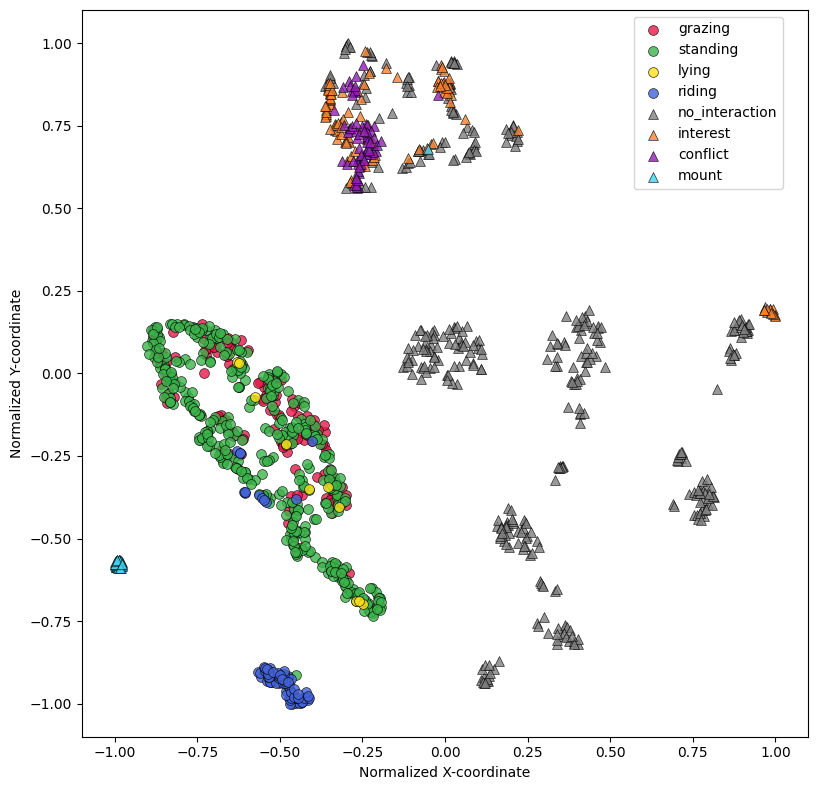

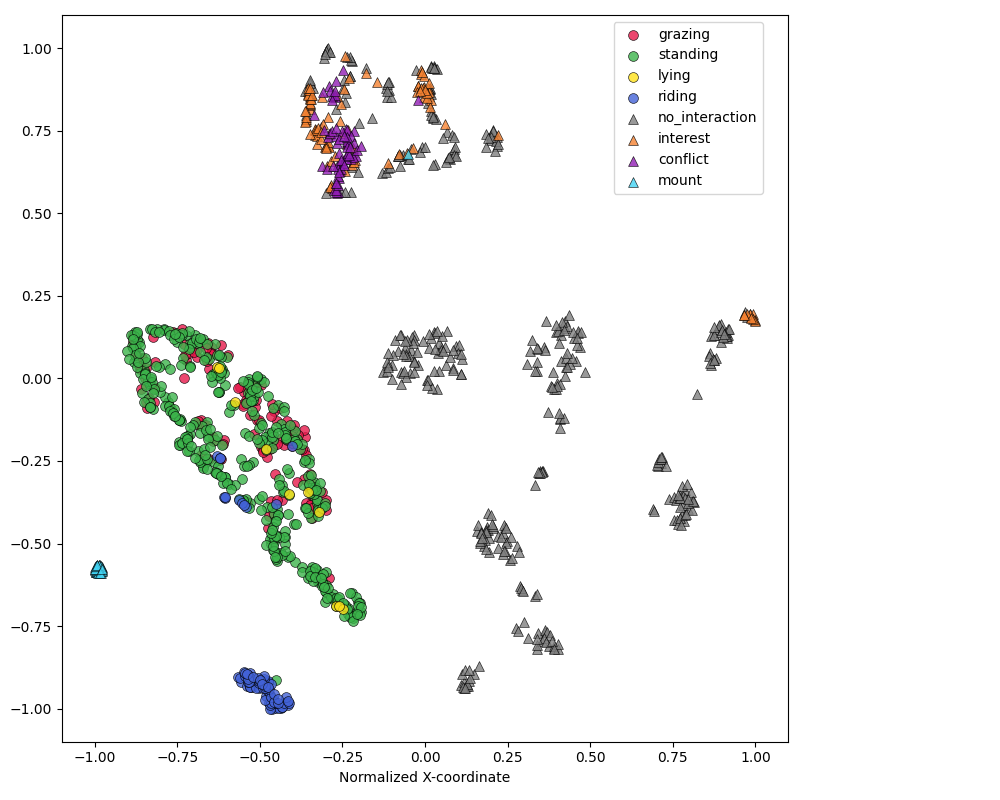

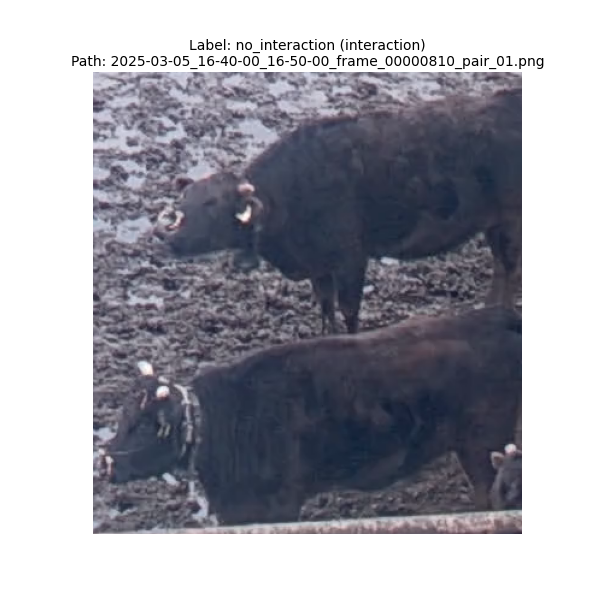

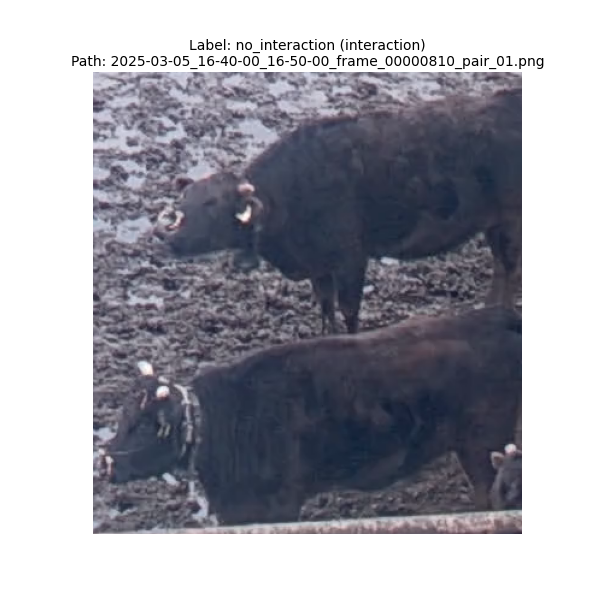

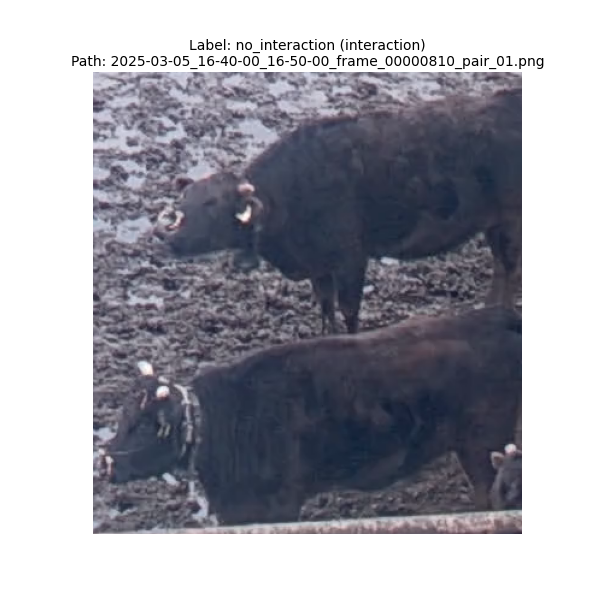

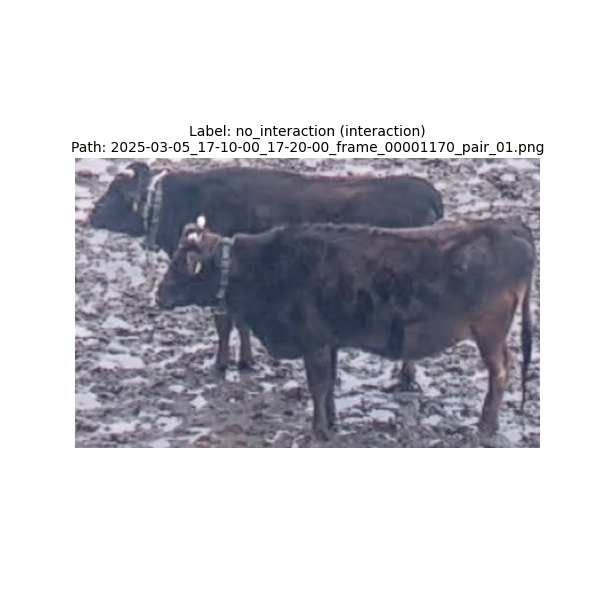

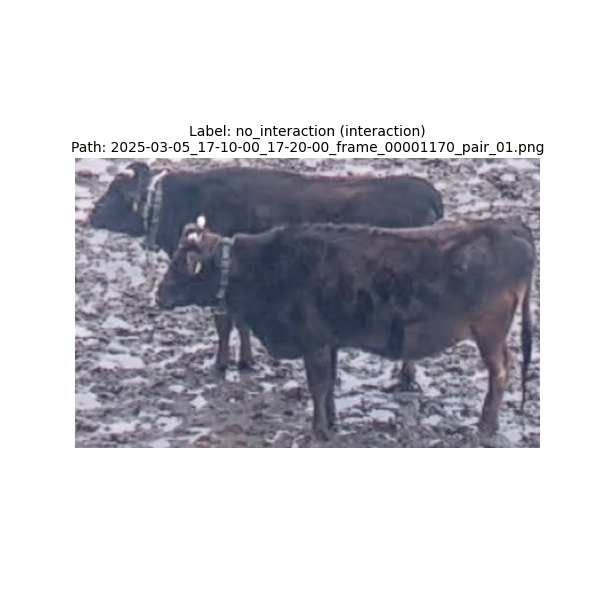

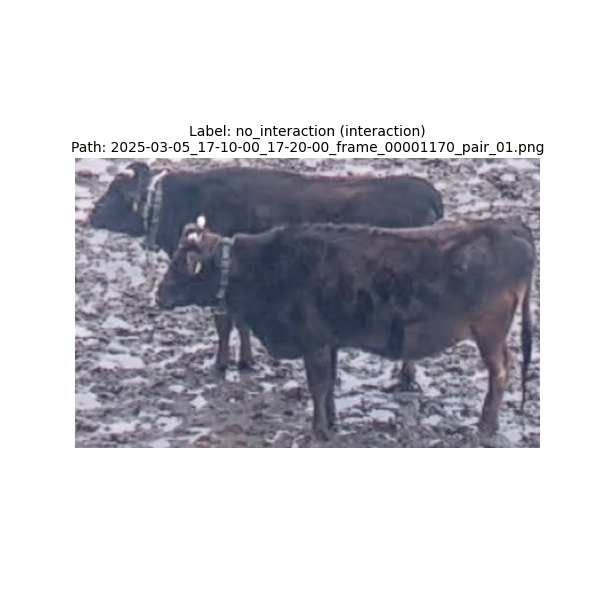

In [39]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
from IPython.display import display

# --------------------------------------------------------------------------
# ▼▼▼ ご指示のあった変更箇所 ▼▼▼
# --------------------------------------------------------------------------

# 1. サンプル数の削減: 各ラベルからランダムに最大n_sample個のサンプルを抽出する
# グループごとのサンプル数がn_sampleを超える場合はn_sampleに、未満の場合はそのままの数にする
n_sample = 400
def sample_data(group):
    if len(group) > n_sample:
        return group.sample(n=n_sample, random_state=1)
    return group

# 'type'と'label'の組み合わせでグループ化し、サンプリングを適用する
df = df.groupby(['type', 'label'], group_keys=False).apply(sample_data).reset_index(drop=True)

# 2. 座標の正規化: x座標とy座標を[-1, 1]の範囲に正規化する
x_min, x_max = df['x'].min(), df['x'].max()
y_min, y_max = df['y'].min(), df['y'].max()

df['x'] = (df['x'] - x_min) / (x_max - x_min)
df['x'] = 2 * df['x'] - 1
df['y'] = (df['y'] - y_min) / (y_max - y_min)
df['y'] = 2 * df['y'] - 1

# --- 以下は元のプロットおよびイベント処理コード ---

fig, ax = plt.subplots(figsize=(10, 8))
markers = {'action': 'o', 'interaction': '^'}
manual_colors = [
    '#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4',
    '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8',
    '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9'
]
gray_color = '#808080'

action_labels_unq = sorted(df[df['type'] == 'action']['label'].unique())
interaction_labels_unq = sorted(df[df['type'] == 'interaction']['label'].unique())

color_map_action = {label: manual_colors[i % len(manual_colors)] for i, label in enumerate(action_labels_unq)}

no_interaction_label_num = None
if 'interaction_map' in locals() and isinstance(interaction_map, dict):
    for num, name in interaction_map.items():
        if name == 'no_interaction':
            no_interaction_label_num = num
            break

color_map_interaction = {}
offset = len(action_labels_unq)
color_index = 0
for label in interaction_labels_unq:
    if label == no_interaction_label_num:
        color_map_interaction[label] = gray_color
    else:
        color_map_interaction[label] = manual_colors[(color_index + offset) % len(manual_colors)]
        color_index += 1

color_map = {
    'action': color_map_action,
    'interaction': color_map_interaction
}

def get_label_name(numeric_label, type_name):
    if type_name == 'action': return action_map.get(numeric_label)
    elif type_name == 'interaction': return interaction_map.get(numeric_label)
    return None

for type_name in df['type'].unique():
    for label_num in df[df['type'] == type_name]['label'].unique():
        subset = df[(df['label'] == label_num) & (df['type'] == type_name)]
        if not subset.empty:
            label_name = get_label_name(label_num, type_name)
            if label_name is not None:
                ax.scatter(subset['x'], subset['y'], c=[color_map[type_name].get(label_num, '#808080')],
                           marker=markers[type_name], label=f'{label_name}', alpha=0.8, s=50,
                           edgecolors='black', linewidths=0.5)

# 凡例をプロットエリアの右外側に配置
handles, current_labels = ax.get_legend_handles_labels()
by_label = dict(zip(current_labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.75, 1), loc='upper left')

# 正規化後のプロットを見やすくするための調整
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel("Normalized X-coordinate")
ax.set_ylabel("Normalized Y-coordinate")
# ax.set_title("Scatter Plot with Normalized Coordinates")

fig.tight_layout(rect=[0, 0, 0.85, 1]) # レイアウトが凡例と重ならないように調整

clicked_points_history = []

def find_closest_point_info(x, y, dataframe):
    distances = np.sqrt((dataframe['x'] - x)**2 + (dataframe['y'] - y)**2)
    closest_idx = distances.idxmin()
    return dataframe.loc[closest_idx]

def onclick(event):
    if event.inaxes != ax:
        return
    
    x, y = event.xdata, event.ydata
    
    closest_info = find_closest_point_info(x, y, df)
    image_path = closest_info['path']
    label_name = get_label_name(closest_info['label'], closest_info['type'])
    
    point_data = {
        'clicked_coordinates': (round(x, 2), round(y, 2)),
        'closest_point_coordinates': (round(closest_info['x'], 2), round(closest_info['y'], 2)),
        'path': image_path,
        'label': label_name,
        'type': closest_info['type'],
        'raw_data': closest_info.to_dict()
    }
    clicked_points_history.append(point_data)
    
    print("--- Point Recorded ---")
    print(f"Clicked at: ({x:.2f}, {y:.2f})")
    print(f"Closest point Label: {label_name}, Type: {closest_info['type']}")
    print(f"Image Path: {image_path}")
    
    try:
        img = Image.open(image_path)
        
        fig_img, ax_img = plt.subplots(figsize=(6, 6))
        window_title = f'ImageViewer: {os.path.basename(image_path)}'
        fig_img.canvas.manager.set_window_title(window_title)
        ax_img.imshow(img)
        title_text = f"Label: {label_name} ({closest_info['type']})\nPath: {os.path.basename(image_path)}"
        ax_img.set_title(title_text, wrap=True, fontsize=10)
        ax_img.axis('off')
        
        plt.show()

    except FileNotFoundError:
        print(f"[Error] Image file not found at path: {image_path}")
    except Exception as e:
        print(f"[Error] Failed to open image: {e}")

cid = fig.canvas.mpl_connect('button_press_event', onclick)

display(fig)